# Parameters estimation
Based on data collected from the watchtower finds the best parameters for the model of the real duckiebot

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

In [2]:
import json
with open("./data_collection.json") as f:
    data = json.loads(f.read())
print("Robot: ", data["duck"])
map_data = data["map_data"]
data = data["data"]

Robot:  DUCKVADER


In [3]:
df = pd.DataFrame(data)
df = df.set_index("sample")
df

,Positions,Inputs,Notes
sample,,,
Left circle,"[[0.5828549931435344, 2.260032743558054, -1.50...","[[0.12, 0.4], [0.12, 0.4], [0.12, 0.4], [0.12,...",Angular speed is wrong
Straight,"[[0.31610534813331903, 2.9663534569084686, -0....","[[0.4, 0.4], [0.4, 0.4], [0.4, 0.4], [0.4, 0.4...",None
Back,"[[1.527203050216432, 1.130807079190915, -1.111...","[[-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [-0...",None
Right circle,"[[1.1846456511238752, 2.7809238853907283, -0.9...","[[0.5, 0.15], [0.5, 0.15], [0.5, 0.15], [0.5, ...",None
Straight line calibrated,"[[0.29815961535562246, 2.979839822281533, -1.5...","[[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5...",None
Left circle calibrated,"[[1.064313836164062, 1.6532245944953257, 0.038...","[[0.15, 0.5], [0.15, 0.5], [0.15, 0.5], [0.15,...",None
Right circle calibrated,"[[1.094857572670193, 2.517572183283877, 0.2655...","[[0.5, 0.15], [0.5, 0.15], [0.5, 0.15], [0.5, ...",None
Backward calibrated,"[[0.6732136774254198, 0.857132173006317, -1.49...","[[-0.5, -0.5], [-0.5, -0.5], [-0.5, -0.5], [-0...",None
Left circle max speed,"[[-0.01380166650430956, -0.021668978088875968,...","[[0.6, 1.0], [0.6, 1.0], [0.6, 1.0], [0.6, 1.0...",


In [12]:
np.array(df.loc["MPC watchtower high freq"].Positions)[:,:2].T

array([[0.37, 0.37, 0.37, ..., 0.41, 0.39, 0.39],
       [2.12, 2.12, 2.12, ..., 1.63, 1.59, 1.59]])

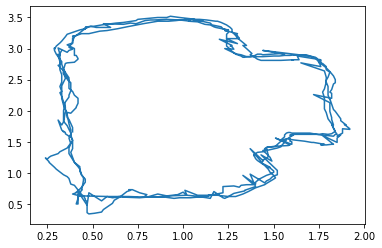

In [18]:
plt.plot(*np.array(df.loc["MPC Loop"].Positions)[:,:2].T)

# Normalizza (anche velocità etc) e metti insieme i campioni
prova idea 2 con N più piccolo (2)

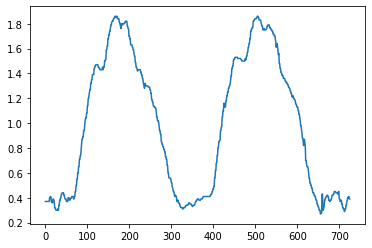

In [15]:
plt.plot(np.array(df.loc["MPC watchtower high freq"].Positions)[:,0])

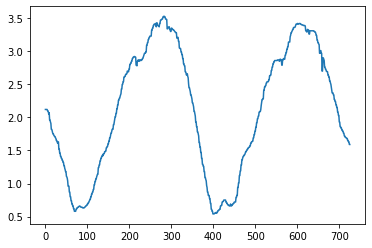

In [17]:
plt.plot(np.array(df.loc["MPC watchtower high freq"].Positions)[:,1])

### The model:

In [86]:
MPC_TIME = 0.1
def F(action, x0, y0, theta0, u1=5, u2=0, u3=0, w1=4, w2=0, w3=0, u_alpha_r=1.5, u_alpha_l=1.5, w_alpha_r=15, w_alpha_l=15, v0=0, w0=0, dt=MPC_TIME):
    # wr, wl
    U = np.array([action[1], action[0]])
    V = U.reshape(U.size, 1)
    V = np.clip(V, -1, +1)

    ## Calculate Dynamics
    # nonlinear Dynamics - autonomous response
    f_dynamic = np.array([[-u1*v0 - u2*w0 + u3*w0**2], [-w1*w0 - w2*v0 - w3*v0*w0]])  
    #input Matrix
    B = np.array([[u_alpha_r, u_alpha_l], [w_alpha_r, -w_alpha_l]])
    # forced response
    f_forced = np.matmul(B, V)
    # acceleration
    x_dot_dot, w_dot_dot = f_dynamic + f_forced

    v1 = v0 + x_dot_dot[0]*dt
    w1 = w0 + w_dot_dot[0]*dt

    # Runge Kutta
    x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
    y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
    theta1 = theta0 + w0*dt

    return x1, y1, theta1, v1, w1

## Estimation

### Using coordinates x and y
 Estimate parameters minimizing the error between estimated and real coordinates x and y

In [87]:
np.array(data[0]["Positions"])[:,:2][2,:]

array([0.58285499, 2.26003274])

In [88]:
idx = [4,5,6,12]
def fun(x0_opt, idxs=idx, N=10):
    """
    Returns the mse between the actual and the estimated positions
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    # w_alpha_r = x0_opt
    target = []
    errors = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        action = data[idx]["Inputs"]
        for i in range(target[-1].shape[0]-1-N):
            x0, y0, theta0, v0, w0 = np.array(data[idx]["Positions"])[i,:5]
            for el in range(N):
                x0, y0, theta0, v0, w0 = F(action[i+el], x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
                errors.append(np.square(x0-target[-1][i+el+1,0]) + np.square(y0-target[-1][i+el+1,1]))
            if i == 300:
                break
    mse = sum(errors)/len(errors)
    return mse

def fun(x0_opt, idxs=idx, N=None):
    """
    Returns the mse between the actual and the estimated positions
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    # w_alpha_r = x0_opt
    positions = []
    target = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        positions.append([x0, y0])
        action = data[idx]["Inputs"]
        for i in range(target[-1].shape[0]-1):
            x0, y0, theta0, v0, w0 = F(action[i], x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
            # x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, w_alpha_r=w_alpha_r, v0=v0, w0=w0)
            positions.append([x0,y0])
            # if N is not None:
            #     if i%N == 0:
            #         x0, y0, theta0 = np.array(data[idx]["Positions"])[i,:3]
    target = np.vstack(target)
    mse = np.square((positions - target)).mean()
    return mse

def fun_return_positions(x0_opt, idxs=idx, N=None):
    """
    Same as fun but returns a list of positions ("partials") easy to plot, keeping fun as fast as needed.
    Every N steps it closes the loop to start from a known position.
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    partials = []
    target = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        partial = [[x0, y0, theta0, v0, w0]]
        actions = data[idx]["Inputs"]
        for i in range(target[-1].shape[0]):
            x0, y0, theta0, v0, w0 = F(actions[i], x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
            partial.append([x0, y0, theta0, v0, w0])
            if N is not None:
                if i%N == 0:
                    x0, y0, theta0, v0, w0 = np.array(data[idx]["Positions"])[i,:5]
        partials.append(partial)
    return partials

In [91]:
n_points = 10
x0 = np.ones(n_points)
bnds = [[-30,30]]*n_points
res = optimize.minimize(lambda x : fun(x, idxs=idx, N=10), x0, method="SLSQP", bounds=bnds)
res

/tmp/ipykernel_14365/399462932.py:10: RuntimeWarning: overflow encountered in double_scalars
  f_dynamic = np.array([[-u1*v0 - u2*w0 + u3*w0**2], [-w1*w0 - w2*v0 - w3*v0*w0]])
/tmp/ipykernel_14365/399462932.py:10: RuntimeWarning: invalid value encountered in double_scalars
  f_dynamic = np.array([[-u1*v0 - u2*w0 + u3*w0**2], [-w1*w0 - w2*v0 - w3*v0*w0]])
/tmp/ipykernel_14365/399462932.py:22: RuntimeWarning: invalid value encountered in cos
  x1 = x0 + v0*dt*np.cos(theta0 + w0*dt/2)
/tmp/ipykernel_14365/399462932.py:23: RuntimeWarning: invalid value encountered in sin
  y1 = y0 + v0*dt*np.sin(theta0 + w0*dt/2)
/tmp/ipykernel_14365/757012996.py:47: RuntimeWarning: overflow encountered in square
  mse = np.square((positions - target)).mean()


     fun: 0.4928383031577039
     jac: array([  29.02771461, -118.8284203 , -122.06969928,  156.20478103,
         14.00587817,  -23.22005523,  -48.45320576,  -54.38364209,
         37.1962443 ,  -42.17520309])
 message: 'Iteration limit reached'
    nfev: 1177
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 1.42281377, -0.1044528 , -0.5923972 , -0.90973376,  6.10433564,
        3.19142516, -0.23516241,  1.55708615, -0.2583259 , -1.91680559])

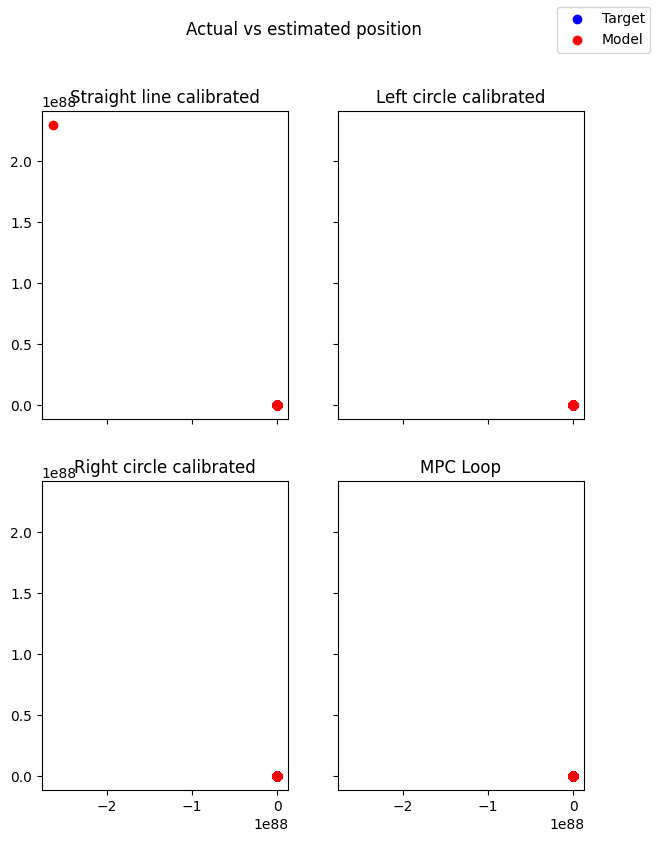

In [92]:
positions = fun_return_positions(res.x, N=10)
n_per_x = 2 if len(positions) > 1 else 1
n_rows = int(len(positions)/2) if len(positions) > 1 else 1
fig, axs = plt.subplots(n_rows,n_per_x, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
axs = np.array(axs)
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target[:300].T, c="b", label="Target")
    ax.scatter(*np.array(position)[:300,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

plotta input

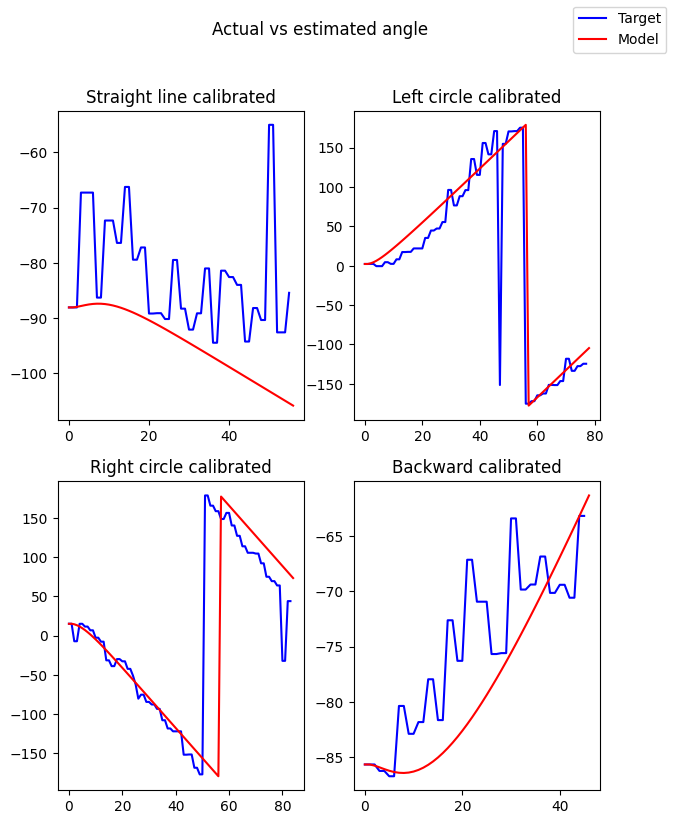

In [ ]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),n_per_x, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated angle")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.rad2deg(np.array(data[idx_]["Positions"])[:,2])
    train = np.array(position)[:,2]
    train = np.mod(train+np.pi, 2*np.pi)-np.pi
    ax.plot(target, c="b", label="Target")
    ax.plot(np.rad2deg(train), c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

In [ ]:
linear_speeds = []
angular_speeds = []
estimated = True
if estimated:
    for poses in positions:
        poses = np.array(poses)
        linear_speed = np.sqrt(np.square(poses[1:, :2] - poses[:-1, :2]).sum(axis=1))/MPC_TIME
        linear_speeds.append(linear_speed)
        angular_speed = (poses[1:, 2] - poses[:-1, 2])/MPC_TIME
        angular_speeds.append(angular_speed)
else:
    target = [data[idx_]["Positions"] for idx in idx]
    for poses in target:
        poses = np.array(poses)
        linear_speed = np.sqrt(np.square(poses[1:, :2] - poses[:-1, :2]).sum(axis=1))/MPC_TIME
        linear_speed = np.cumsum(linear_speed, dtype=float)
        linear_speed[5:] = linear_speed[5:] - linear_speed[:-5]
        linear_speeds.append(linear_speed/5)
        angular_speed = (poses[1:, 2] - poses[:-1, 2])/MPC_TIME
        angular_speeds.append(angular_speed)
linear_speeds[-1] *= -1

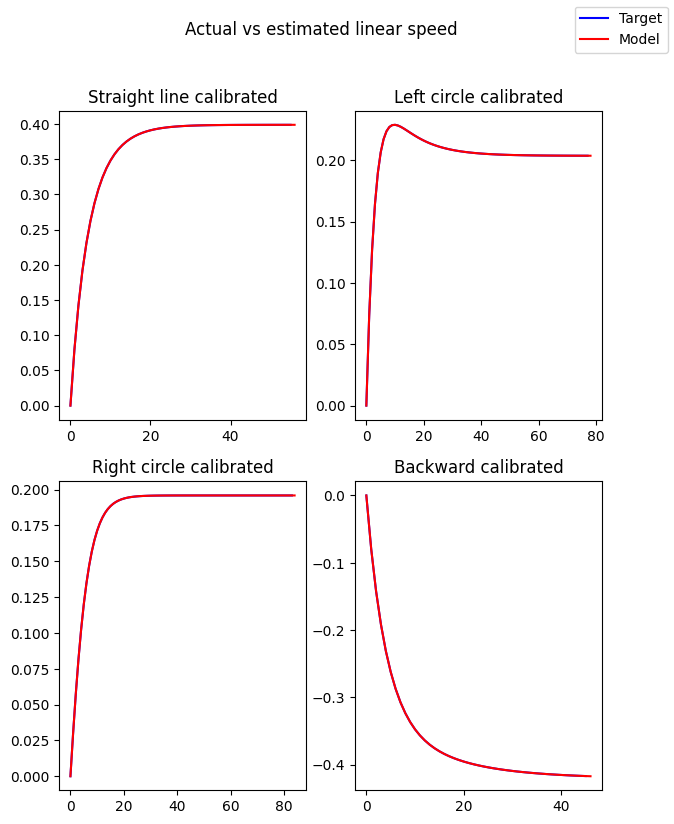

In [ ]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),n_per_x, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated linear speed")
for idx_, ax, position, linear_speed in zip(idx, axs.reshape(-1), positions, linear_speeds):
    target = linear_speed
    train = np.array(position)[:,3]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

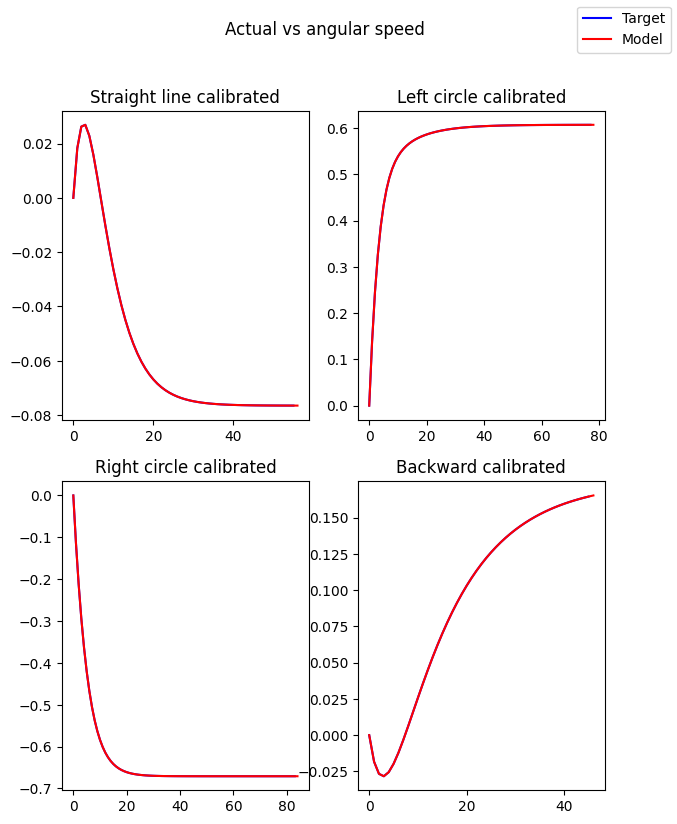

In [ ]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),n_per_x, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs angular speed")
for idx_, ax, position, angular_speed in zip(idx, axs.reshape(-1), positions, angular_speeds):
    target = angular_speed
    train = np.array(position)[:,4]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

The speeds make a lot of sense.

## Using linear and angular speed
Assuming the previous positions to be correct use them to compute the speed and rebuild the loss function to minimize the error wrt the speed

In [145]:
def fun(x0_opt, idxs=idx):
    """
    Returns the mse between the predicted angles and the actual angles
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    speeds = []
    target = np.vstack((np.hstack(linear_speeds), np.hstack(angular_speeds))).T
    for idx in idxs:
        elements = np.array(data[idx]["Positions"])
        x0, y0, theta0 = elements[0,:3]
        v0, w0 = 0, 0
        positions.append([v0, w0])
        action = data[idx]["Inputs"][0]
        for _ in range(elements.shape[0]):
            x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0, dt=MPC_TIME)
            speeds.append([v0,w0])
    mse = np.square((speeds - target)).mean()
    return mse

In [146]:
x0 = np.ones(10)
bnds = [[-30,30]]*10
res = optimize.minimize(fun, x0, method="SLSQP", bounds=bnds)
res

     fun: 0.00029183053169350257
     jac: array([ 3.11997912e-04, -3.64875341e-05,  1.69839113e-04,  3.20135248e-04,
       -4.05983104e-04, -2.66225579e-05, -3.35611476e-05,  1.34167105e-04,
        9.63532548e-05, -1.66956295e-04])
 message: 'Optimization terminated successfully'
    nfev: 387
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([ 2.14148837,  0.12200042, -0.28237442,  1.3380637 ,  0.40072379,
        1.30781483,  1.03762896,  0.62189597,  2.9650673 ,  2.89169198])

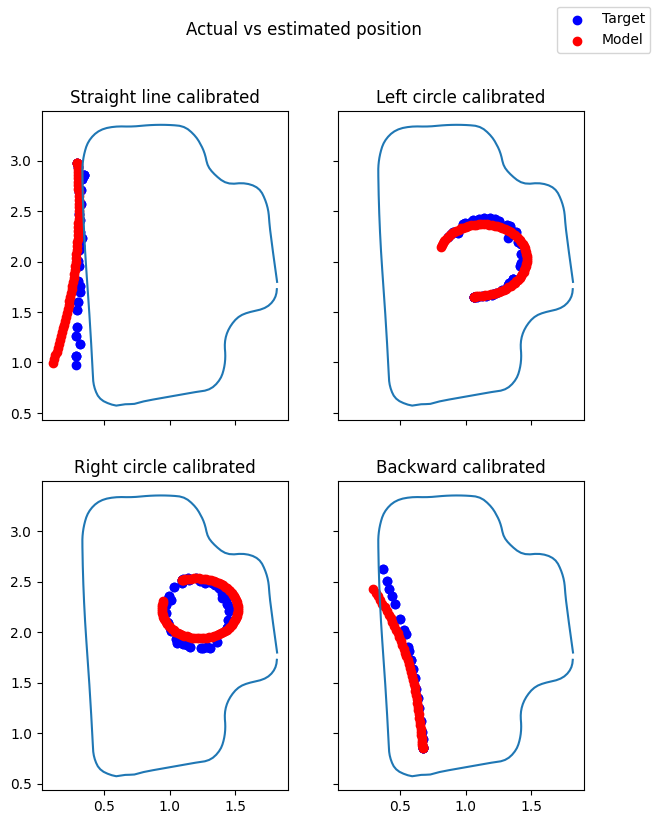

In [147]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target.T, c="b", label="Target")
    ax.scatter(*np.array(position)[:,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

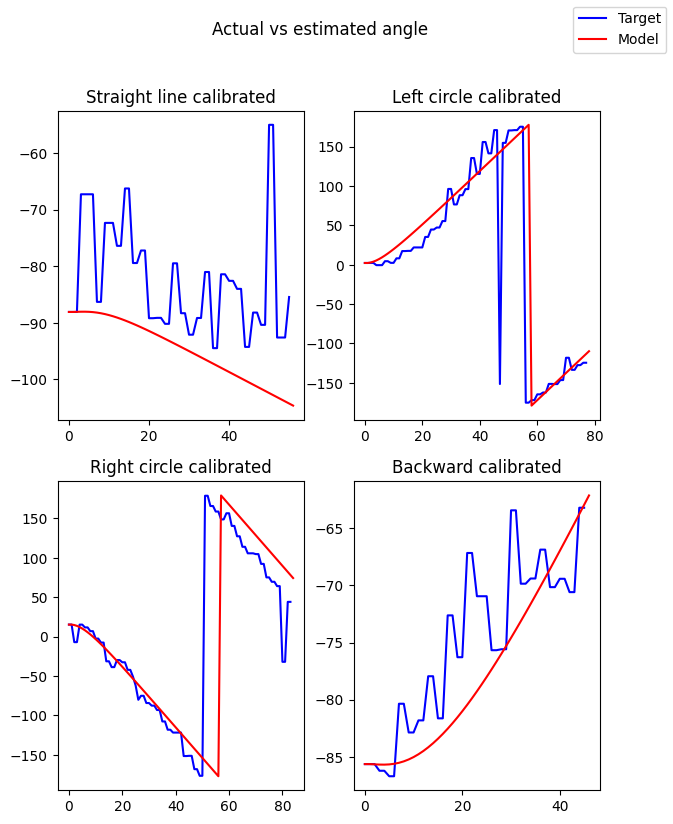

In [148]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated angle")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.rad2deg(np.array(data[idx_]["Positions"])[:,2])
    train = np.array(position)[:,2]
    train = np.mod(train+np.pi, 2*np.pi)-np.pi
    ax.plot(target, c="b", label="Target")
    ax.plot(np.rad2deg(train), c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

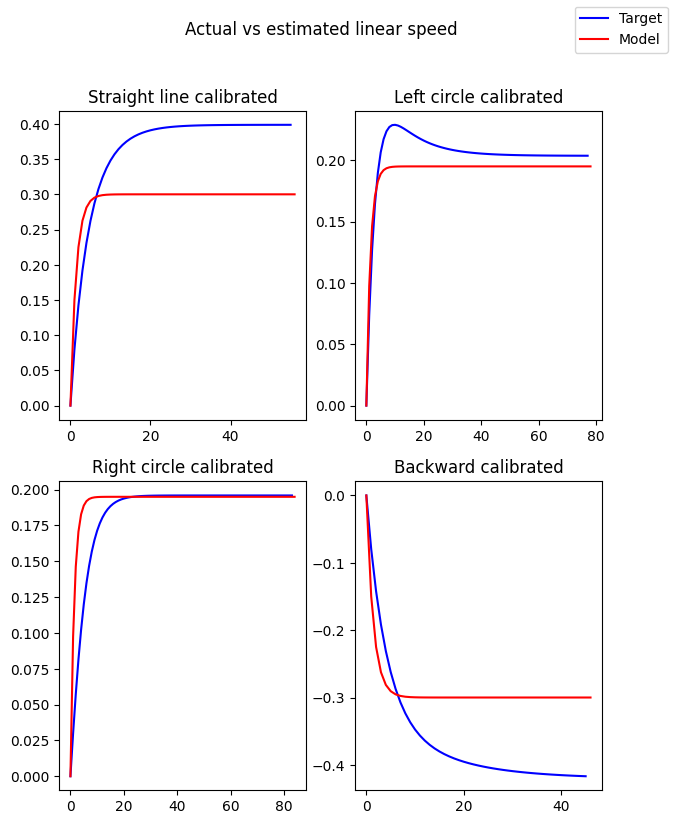

In [149]:
positions = fun_return_positions([5,0,0,4,0,0,1.5,1.5,15,15])
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs estimated linear speed")
for idx_, ax, position, linear_speed in zip(idx, axs.reshape(-1), positions, linear_speeds):
    target = linear_speed
    train = np.array(position)[:,3]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

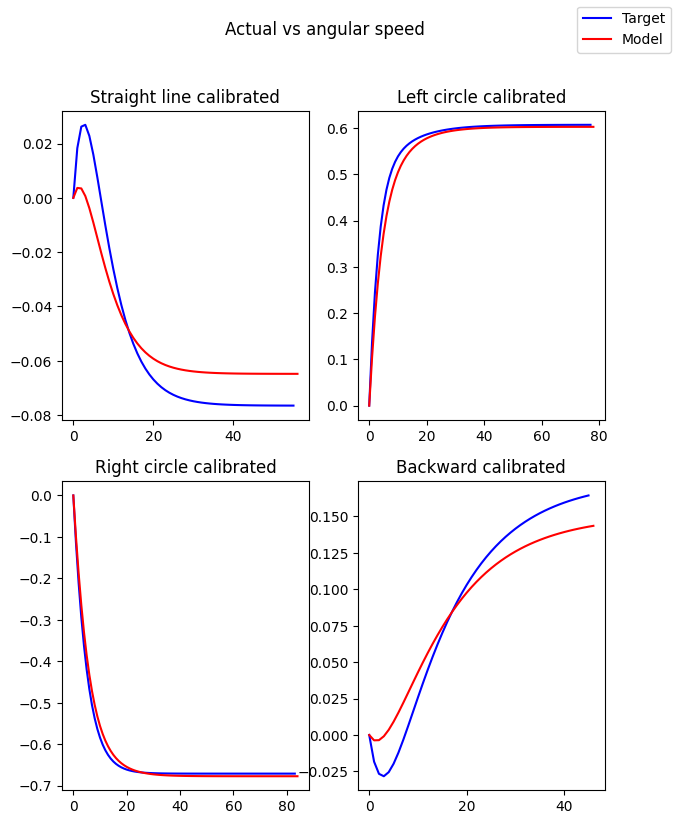

In [150]:
positions = fun_return_positions(res.x)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))))
fig.suptitle("Actual vs angular speed")
for idx_, ax, position, angular_speed in zip(idx, axs.reshape(-1), positions, angular_speeds):
    target = angular_speed
    train = np.array(position)[:,4]
    ax.plot(target, c="b", label="Target")
    ax.plot(train, c="r", label="Model")
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

In [151]:
u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = res.x
points = []
action = [1,0.2]
x0, y0, theta0, v0, w0 = 0, 0, 0, 0, 0
for i in range(23):
    x0, y0, theta0, v0, w0 = F(action, x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0, dt=MPC_TIME)
    points.append([x0,y0,theta0,v0,w0])
points = np.array(points)

In [152]:
points[:,3].max()

0.29206192071547105

## Manual test

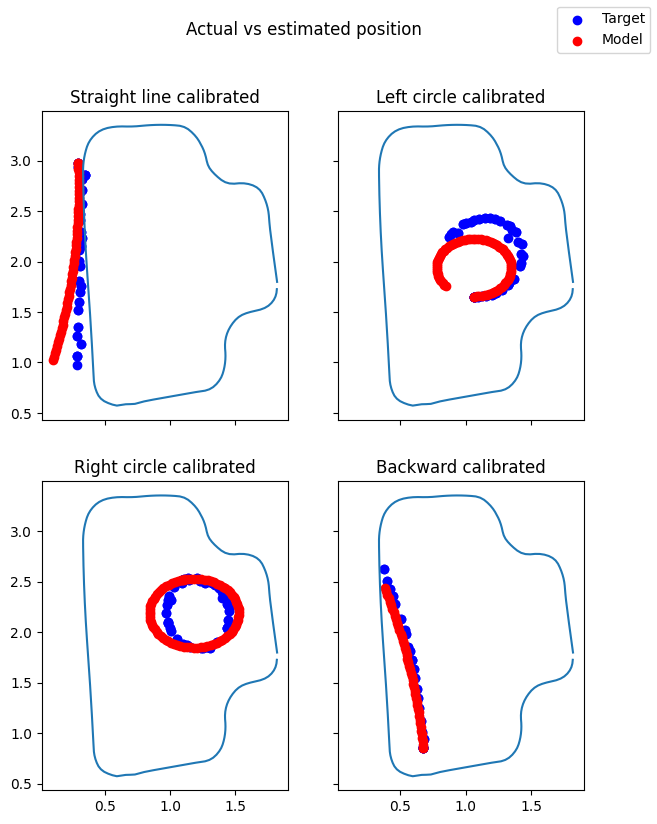

In [154]:
original = [5,0,0,4,0,0,1.5,1.5,15,15]
thesis = [7.662, 0.325, -0.050, 6.826, -4.929, -6.515, 2.755, 2.741, 10.8, 14.662]

manual = [7.662, 0.325, -0.050, 6.826, 0, 0, 2.755, 2.741, 14, 14.662]

positions = fun_return_positions(manual)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idx, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target.T, c="b", label="Target")
    ax.scatter(*np.array(position)[:,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

### Validate the model on the MPC

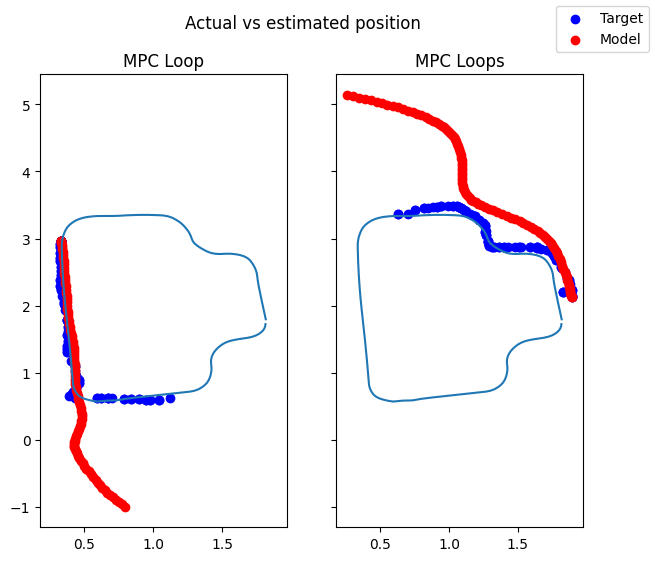

In [155]:
params = [2.14148837, 0.12200042, -0.28237442, 1.3380637, 0.40072379, 1.30781483, 1.30781483, 1.03762896, 2.9650673, 2.89169198]

idxs = [12, 13, 14]
positions = fun_return_positions(params, idxs=idxs)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idxs, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target[:100].T, c="b", label="Target")
    ax.scatter(*np.array(position)[:100,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")

In [156]:
def fun_return_positions_closed_loop(x0_opt, idxs=idx, N=10):
    """
    Same as fun but returns a list of positions ("partials") easy to plot, keeping fun as fast as needed.
    Every N steps it closes the loop to start from a known position.
    """
    u1, u2, u3, w1, w2, w3, u_alpha_r, u_alpha_l, w_alpha_r, w_alpha_l = x0_opt
    partials = []
    target = []
    for idx in idxs:
        target.append(np.array(data[idx]["Positions"])[:,:2])
        x0, y0, theta0 = np.array(data[idx]["Positions"])[0,:3]
        v0, w0 = 0, 0
        partial = [[x0, y0, theta0, v0, w0]]
        actions = data[idx]["Inputs"]
        for i in range(target[-1].shape[0]):
            x0, y0, theta0, v0, w0 = F(actions[i], x0=x0, y0=y0, theta0=theta0, u1=u1, u2=u2, u3=u3, w1=w1, w2=w2, w3=w3, u_alpha_r=u_alpha_r, u_alpha_l=u_alpha_l, w_alpha_r=w_alpha_r, w_alpha_l=w_alpha_l, v0=v0, w0=w0)
            partial.append([x0, y0, theta0, v0, w0])
            if i%N == 0:
                x0, y0, theta0 = np.array(data[idx]["Positions"])[i,:3]
        partials.append(partial)
    return partials

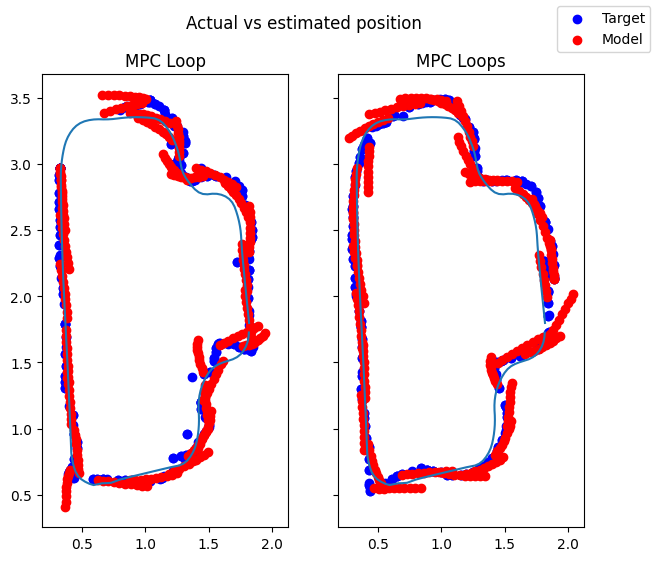

In [170]:
params = [2.14148837, 0.12200042, -0.28237442, 1.3380637, 0.40072379, 1.30781483, 1.30781483, 1.03762896, 2.9650673, 2.89169198]

idxs = [12, 13, 14]
positions = fun_return_positions_closed_loop(params, idxs=idxs, N=10)
fig, axs = plt.subplots(int(len(positions)/2),2, dpi=100, figsize=(7, int(9/4*len(positions))), sharex=True, sharey=True)
fig.suptitle("Actual vs estimated position")
for idx_, ax, position in zip(idxs, axs.reshape(-1), positions):
    target = np.array(data[idx_]["Positions"])[:,:2]
    ax.scatter(*target[:300].T, c="b", label="Target")
    ax.scatter(*np.array(position)[:300,:2].T, c="r", label="Model")
    ax.plot(*np.array(map_data).reshape(-1,2).T)
    ax.set_title(data[idx_]["sample"])
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines,labels = [sum(ll, []) for ll in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper right")